In [1]:
%matplotlib inline
timeSz = 32
from MakeModels import *
encoder = makeEncoder(timeSz)
decoder = makeDecoder()
autoencoder = makeAutoencoder(encoder,decoder)

autoencoder.load_weights('/home/ubuntu/SoftRobotRepresentation/ModelPrettyGoodBottleneck25.h5', by_name=True)

nFeatures = autoencoder.layers[-2].output_shape[-1]+4

Using TensorFlow backend.


In [ ]:
decoder.summary()

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import sklearn
import sklearn.decomposition as decomposition
from IPython.core.debugger import Pdb

feats = np.load('/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy')

feats = feats[:,:-4]

def makeFeatureGood(feature):
    feature = np.expand_dims(feature,axis=0)
    feature = np.expand_dims(feature,axis=0)
    feature = np.expand_dims(feature,axis=0)
    return feature


pca = decomposition.PCA(n_components=5)
pca.fit(feats)
print pca.components_.shape

(5, 25)


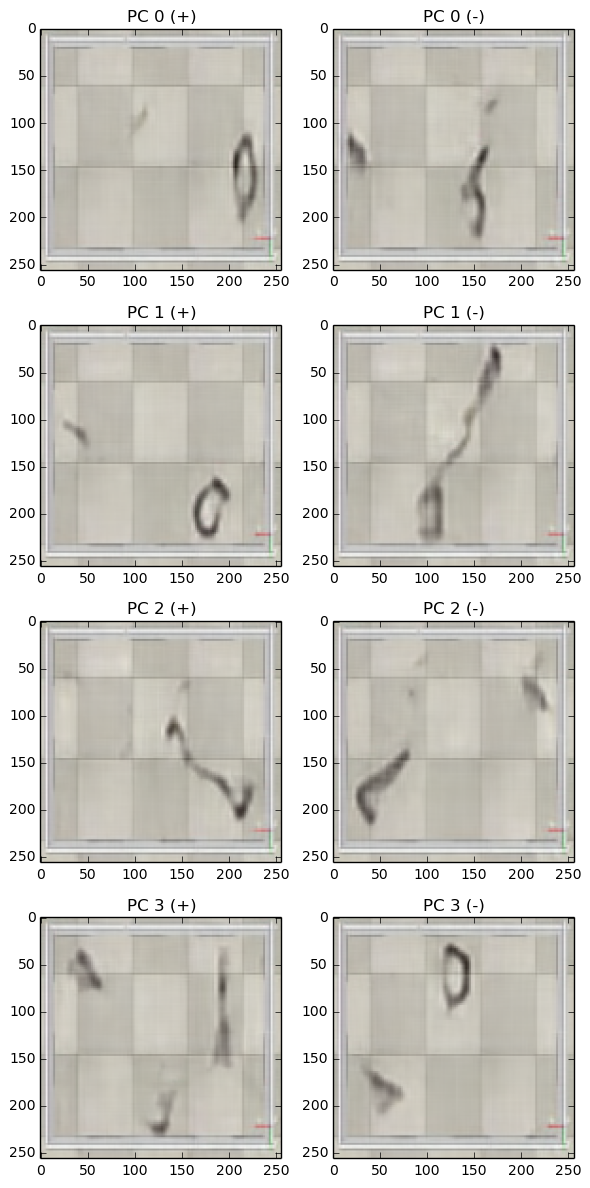

In [11]:
# mn = makeFeatureGood(np.mean(feats))
mn = np.mean(feats)

# im_out = decoder.predict(makeFeatureGood(mn))
# plt.figure()
# plt.imshow(im_out[0,:])

ncomponents = 4
fig,axes = plt.subplots(nrows=ncomponents,ncols=2,figsize=(6,12))
for i in range(ncomponents):
    im_out = decoder.predict(makeFeatureGood(mn+pca.components_[i,:]*5e3))
    plt.subplot(ncomponents,2,2*i+1)
    plt.imshow(im_out[0,:])
    plt.title('PC %d (+)' % i)
    im_out = decoder.predict(makeFeatureGood(mn-pca.components_[i,:]*5e3))
    plt.subplot(ncomponents,2,2*i+2)
    plt.imshow(im_out[0,:])
    plt.title('PC %d (-)' % i)
    
fig.tight_layout()
fig.savefig('/home/ubuntu/SoftRobotRepresentation/Plots/PCA.pdf',format='pdf')

In [13]:
from sklearn.neighbors import NearestNeighbors


randomFeatIdxs = np.random.randint(0,feats.shape[0],size=(2000,))
randomFeats = feats[randomFeatIdxs,:]
print randomFeats.shape 
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(randomFeats)

(2000, 25)


In [14]:
distances, indices = nbrs.kneighbors(randomFeats)

print indices

[[   0 1280  436 1018 1065]
 [   1  914 1847 1252 1341]
 [   2 1897  341  615 1511]
 ..., 
 [1997 1396  480 1715   18]
 [1998 1100  625  540  221]
 [1999  523   25  923 1300]]


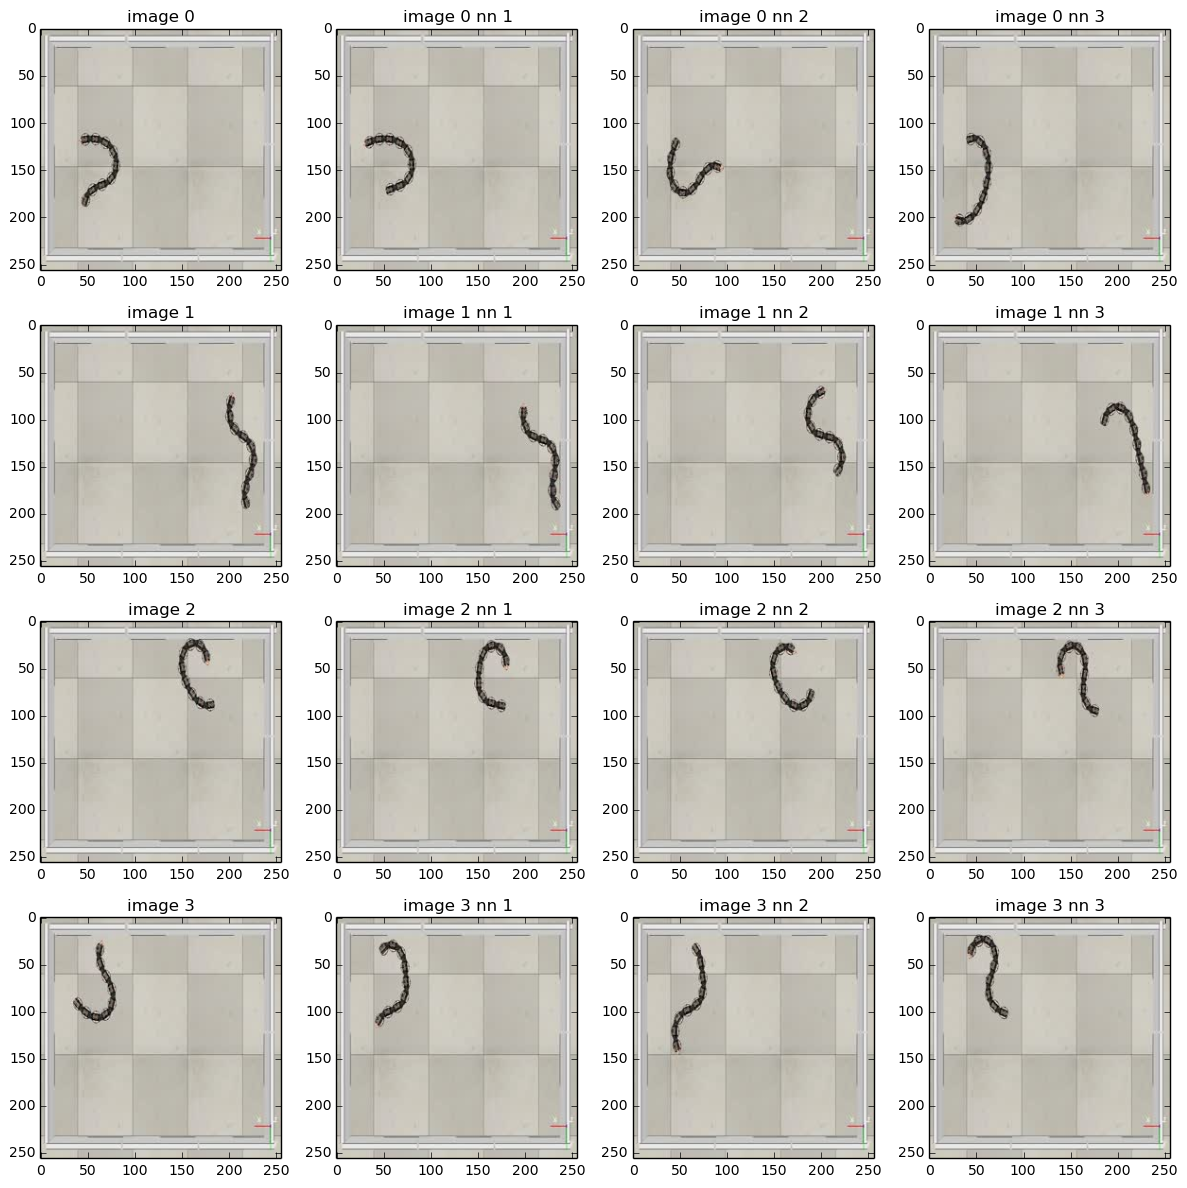

In [17]:
from IPython.core.debugger import Pdb

npoints = 4
idxs = np.random.randint(0,indices.shape[0],npoints)

valPath = '/home/ubuntu/SoftRobotRepresentation/Data/Training/0/'
def indexToImage(index):
    fname = '%s%06d.jpg'%(valPath,index)
    return plt.imread(fname)

# plt.figure(figsize=(12,12))/
fig,axes = plt.subplots(nrows=npoints,ncols=npoints,figsize=(12,12))
for i,idx in enumerate(idxs):
    plt.subplot(npoints,npoints,i*4+1)
    plt.imshow(indexToImage(randomFeatIdxs[idx]))
    plt.title('image %d'%i)
    for j in range(1,npoints):
        plt.subplot(npoints,npoints,i*npoints+j+1)
        plt.title('image %d nn %d'%(i,j))
        plt.imshow(indexToImage(randomFeatIdxs[indices[idx,j+1]]))
        
fig.tight_layout()
fig.savefig('/home/ubuntu/SoftRobotRepresentation/Plots/NN.pdf',format='pdf')
    

(52850, 2)
(52850, 25)
13111
yep
[ 4416.64074682  4404.92888558  4431.17211237 ...,  3199.67012012
  3199.67012012  3199.67012012]
[13111 13110 13112 ..., 22619 22618 22620]


(array([  1.50000000e+01,   1.52000000e+02,   2.86000000e+02,
          6.14000000e+02,   1.35700000e+03,   1.84100000e+03,
          1.43050000e+04,   2.70740000e+04,   6.82100000e+03,
          3.85000000e+02]),
 array([    0.        ,   612.85899672,  1225.71799345,  1838.57699017,
         2451.4359869 ,  3064.29498362,  3677.15398034,  4290.01297707,
         4902.87197379,  5515.73097051,  6128.58996724]),
 <a list of 10 Patch objects>)

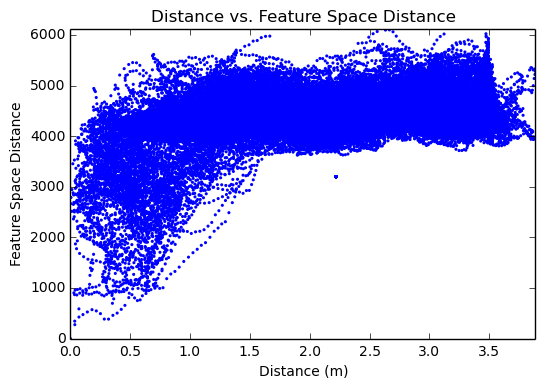

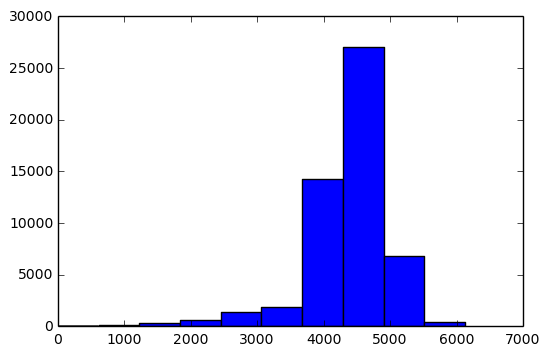

In [24]:
featuresTotal = np.load('/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy')
featuresTotal = featuresTotal[:,:-2]

pointIdxs = range(featuresTotal.shape[0])#np.random.randint(0,featuresTotal.shape[0],npoints)
featPos = featuresTotal[pointIdxs,-2:]
print featPos.shape
featOnly = featuresTotal[pointIdxs,:-2]
print featOnly.shape

randomIndex = 13111#np.random.randint(0,featPos.shape[0],1)
print randomIndex

pos = featPos[randomIndex,:]
feat = featOnly[randomIndex,:]

deltaPos = pos-featPos
deltaFeat = feat-featOnly

distPos = np.sum(deltaPos**2,axis=1)**(1./2)
distFeat = np.sum(deltaFeat**2,axis=1)**(1./2)

plt.scatter(distPos,distFeat,marker='.',linewidths=0)
plt.xlabel('Distance (m)')
plt.ylabel('Feature Space Distance')
plt.title('Distance vs. Feature Space Distance')
plt.ylim([0, np.max(distFeat)])
plt.xlim([0, np.max(distPos)])
plt.savefig('/home/ubuntu/SoftRobotRepresentation/Plots/DistVsFeatDist.pdf',format='pdf')

print "yep"
np.sort(distFeat)
print distFeat

print np.argsort(distFeat)

plt.figure()
plt.hist(distFeat)

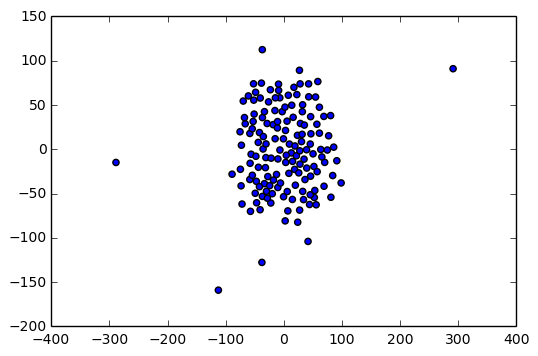

In [53]:
from sklearn import manifold

npoints = 1500
subsampled = feats[np.random.randint(0,feats.shape[0],npoints),:]
tsne = manifold.TSNE()
X = tsne.fit_transform(subsampled)

plt.scatter(X[:,0],X[:,1])